In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from tqdm import tqdm
import os
from chinese_calendar import is_holiday, is_workday
import datetime

In [2]:
with open('/data6/peiyan/SH-METR/results/station_lightLabels.pkl','rb') as infile:
    stationLabel = pickle.load(infile)

In [6]:
stationInfo = pd.read_csv('../../Metro/station_transInfo_cleaned.csv')
dict_staionName = dict(zip(stationInfo['stationID'], stationInfo['name']))
dict_stationLoc = dict(zip(stationInfo['stationID'], zip(stationInfo['lon'],stationInfo['lat'])))
stationID_List = list(stationInfo['stationID'])

GridPop = np.load('../../MetaData/Shanghai_population_grid.npy')
GridPop.shape

(145, 139)

In [3]:
root_path = '/data6/peiyan/SH-METR/results/' 
raw_data = pd.read_csv(os.path.join(root_path, 'metroData_Demandflow_10.csv'))
raw_data

,date,timeslot,startTime,endTime,station,inFlow,outFlow,CinFlow,HO_inFlow,WO_inFlow,CoutFlow,HO_outFlow,WO_outFlow
0,20170501,0,60000,61000,112,29,32,9,15,0,11,13,1
1,20170501,0,60000,61000,113,142,102,40,51,4,30,41,1
2,20170501,0,60000,61000,114,66,35,17,19,7,12,10,2
3,20170501,0,60000,61000,119,23,14,6,9,0,1,3,2
4,20170501,0,60000,61000,124,17,21,2,4,2,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788887,20170831,12545,225000,230000,2053,6,26,2,0,1,8,6,4
3788888,20170831,12545,225000,230000,2054,18,110,5,2,6,19,39,12
3788889,20170831,12545,225000,230000,2055,5,80,0,1,2,19,23,6
3788890,20170831,12545,225000,230000,2056,33,99,8,4,1,20,31,6


In [4]:
def FetchPop(stationID, dict_stationLoc, GridPop): 
    stationLon = dict_stationLoc[stationID][0]  #WGS84
    stationLat = dict_stationLoc[stationID][1]

    leftUp = (120.828879, 31.879505)
    resolution =  0.008333

    col_idx =int((stationLon - leftUp[0]) // resolution)
    row_idx = int((leftUp[1] - stationLat) // resolution)

    totalPop = 0
    for i in range(row_idx - 1, row_idx + 2):
        for j in range(col_idx - 1, col_idx + 2):
            totalPop = GridPop[i,j]
    # totalPop = GridPop[row_idx, col_idx]

    return totalPop

In [7]:
# 统计以 station 为家的乘客数量
# stationHomeCount = [0] * len(stationID_List)
# for userID, userInfo in tqdm(stationLabel.items()):
#     homeID = userInfo['h']
#     if homeID != -1:
#         stationHomeCount[stationID_List.index(homeID)] += 1

# 统计以station为中心 3*3km 的人口数量
stationNearbyPop = [0] * len(stationID_List)
for stationID in tqdm(stationID_List):
    stationNearbyPop[stationID_List.index(stationID)] = FetchPop(stationID, dict_stationLoc, GridPop)

100%|██████████| 302/302 [00:00<00:00, 107747.52it/s]


In [39]:
stationAvgFlow = [[] for i in range(len(stationID_List))] # inFlow + outFlow 按天平均

curr_date = 20170501
currDayFlow = [0 for i in range(len(stationID_List))]
for line in tqdm(raw_data.values):
    if curr_date != line[0]:
        for i in range(len(stationID_List)):
            stationAvgFlow[i].append(currDayFlow[i])
        curr_date = line [0]
        currDayFlow = [ 0 for i in range(len(stationID_List))]

    currDayFlow[stationID_List.index(line[4])] += (line[5] + line[6])

stationAvgFlow = [np.mean(i) for i in stationAvgFlow]
stationAvgFlow = np.array(stationAvgFlow)

100%|██████████| 3788892/3788892 [00:27<00:00, 138710.19it/s]


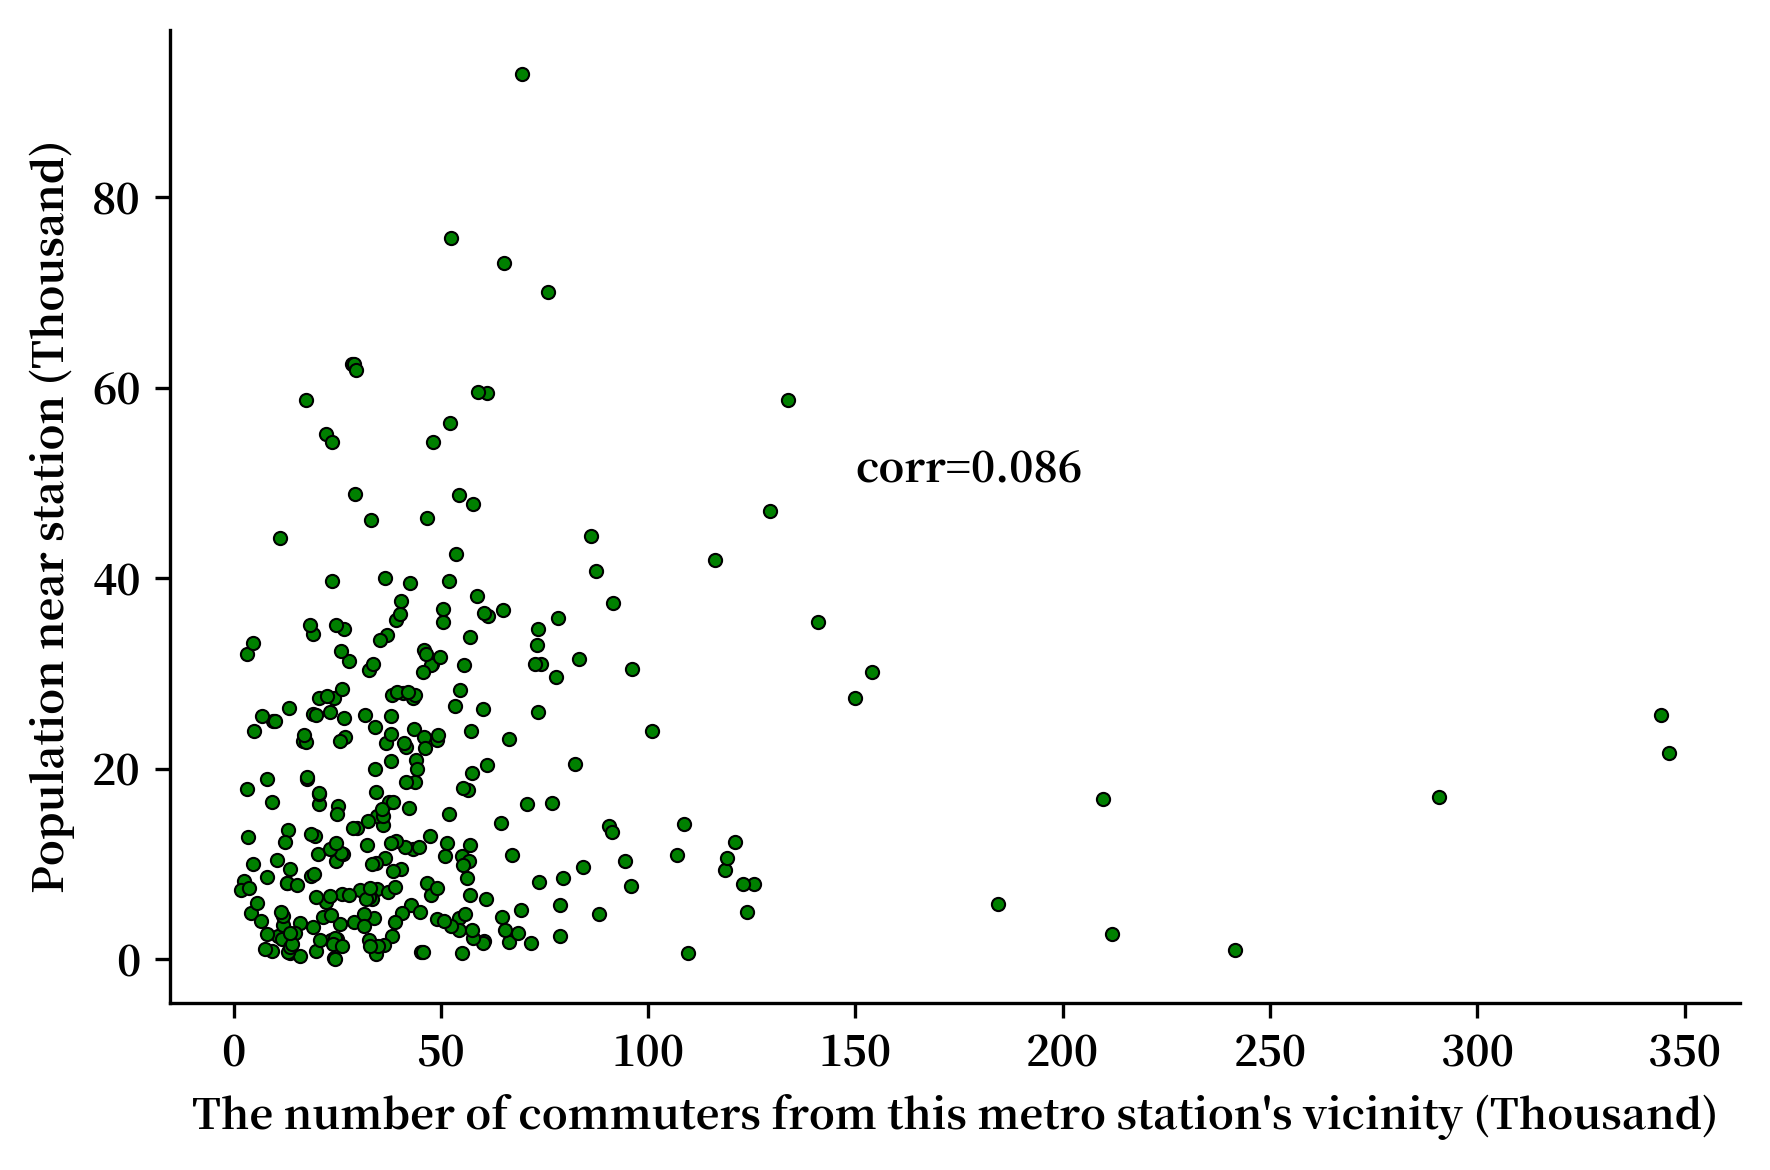

In [64]:
fig = plt.figure(figsize=(6, 4), dpi=300)
stationHomeCount = np.array(stationHomeCount)
stationNearbyPop = np.array(stationNearbyPop)
# norm_stationHomeCount = (stationHomeCount-np.min(stationHomeCount))/(np.max(stationHomeCount)-np.min(stationHomeCount))
# norm_stationNearbyPop = (stationNearbyPop-np.min(stationNearbyPop))/(np.max(stationNearbyPop)-np.min(stationNearbyPop))
norm_stationHomeCount = stationHomeCount/1000
norm_stationNearbyPop = stationNearbyPop/1000
correlation = np.corrcoef(norm_stationHomeCount, norm_stationNearbyPop)[0, 1]
plt.scatter(norm_stationHomeCount,norm_stationNearbyPop, s=10, facecolor='green', edgecolors='black', linewidths=0.5)
plt.ylabel("Population near station (Thousand)")
plt.xlabel("The number of commuters from this metro station's vicinity (Thousand)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.text(150, 50, 'corr='+str(round(correlation,3)))
plt.tight_layout()

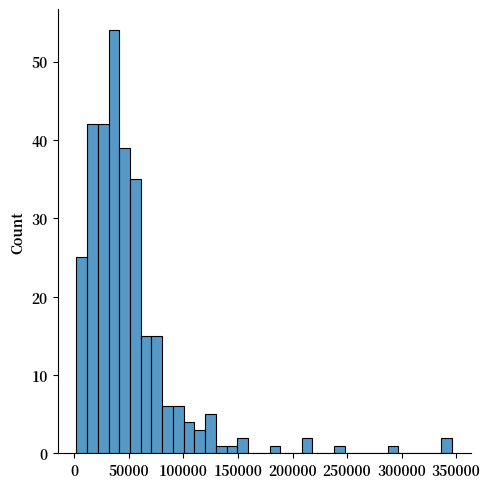

In [81]:
import seaborn as sns
sns.displot(stationHomeCount)

In [84]:
for idx, homeCount in enumerate(stationHomeCount):
    if homeCount > 200000:
        print(dict_staionName[stationID_List[idx]])

莲花路
徐泾东
莘庄
虹桥火车站
上海南站
上海火车站


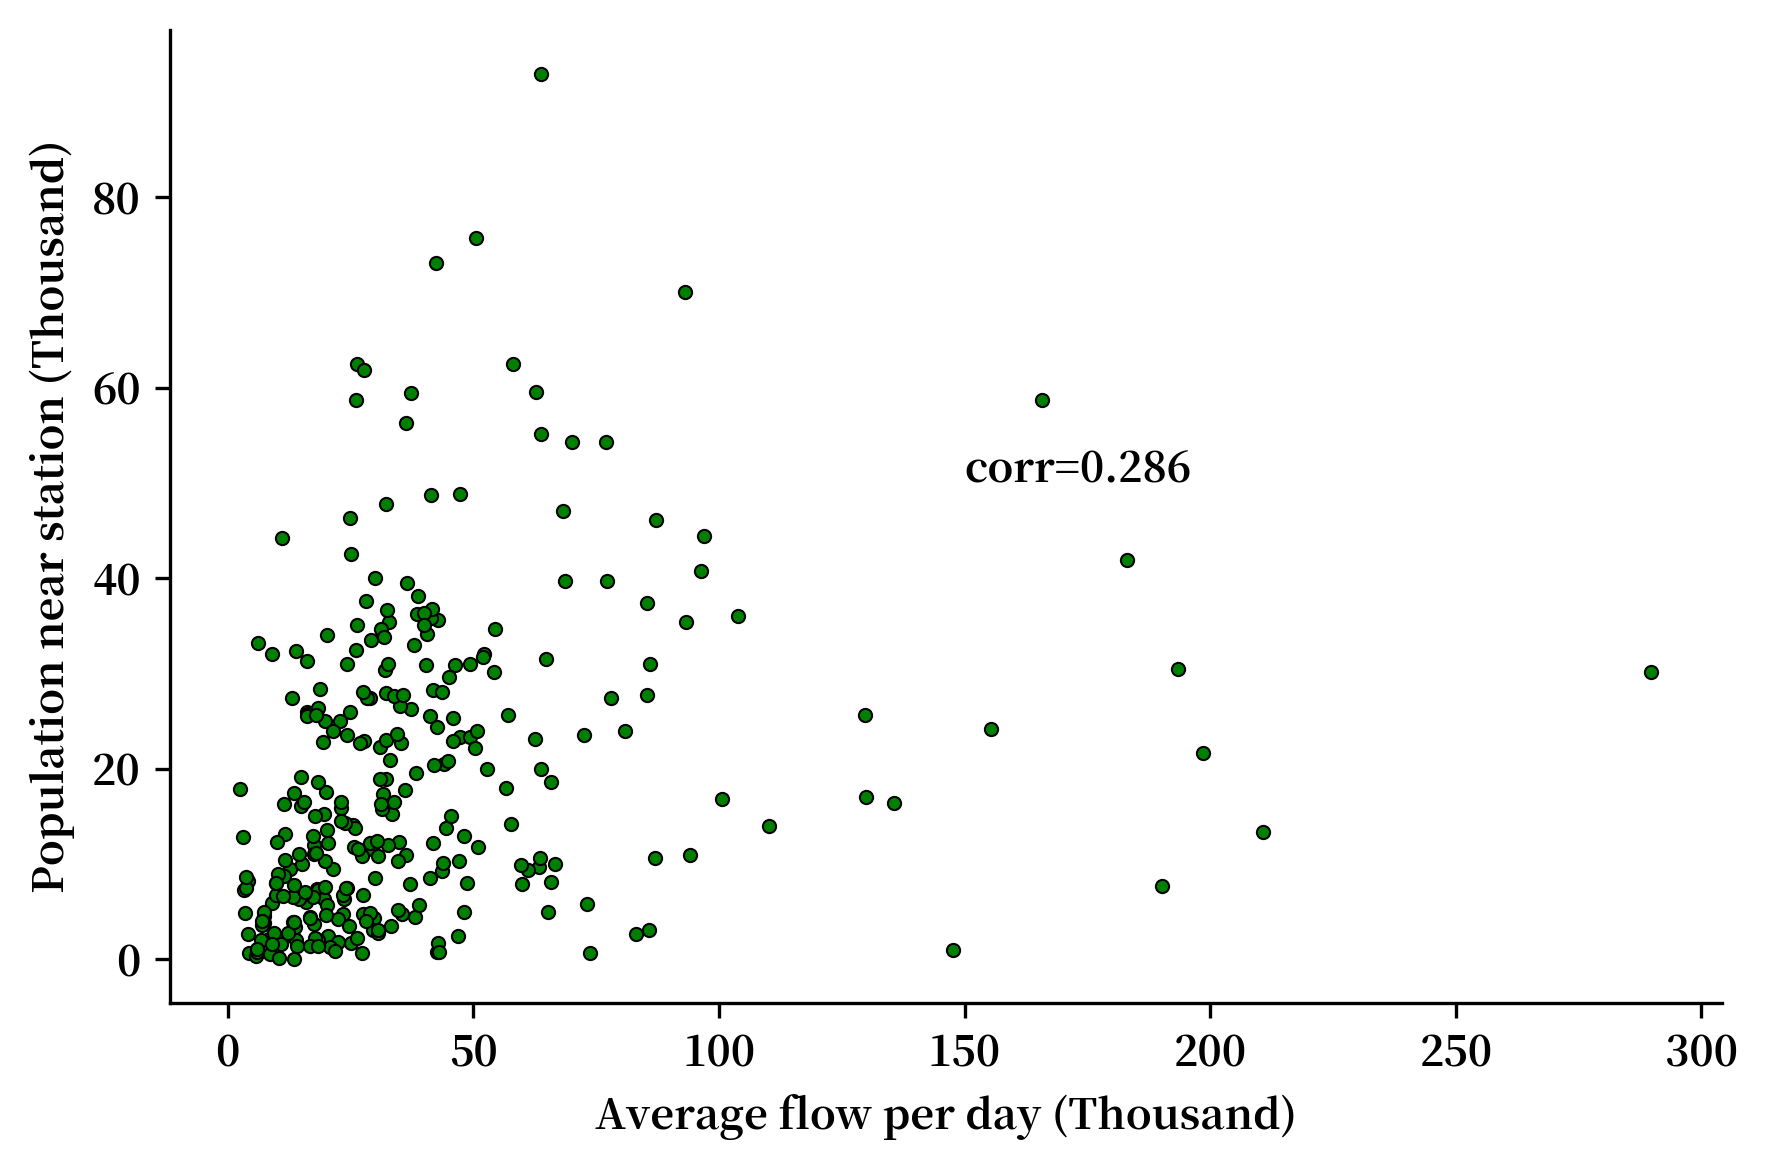

In [83]:
fig = plt.figure(figsize=(6, 4), dpi=300)
stationAvgFlow = np.array(stationAvgFlow)
stationNearbyPop = np.array(stationNearbyPop)

norm_stationAvgFlow = stationAvgFlow/1000
norm_stationNearbyPop = stationNearbyPop/1000
correlation = np.corrcoef(norm_stationAvgFlow, norm_stationNearbyPop)[0, 1]
plt.scatter(norm_stationAvgFlow,norm_stationNearbyPop, s=10, facecolor='green', edgecolors='black', linewidths=0.5)
plt.ylabel("Population near station (Thousand)")
plt.xlabel("Average flow per day (Thousand)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.text(150, 50, 'corr='+str(round(correlation,3)))
plt.tight_layout()